# MLP
Like MLP_269 but run on every cell line individually.

In [13]:

from datetime import datetime
print(datetime.now())

2023-04-19 17:54:55.487296


In [14]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
    MODEL_DIR = '/Users/jasonmiller/WVU/Localization/Models/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [15]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=250 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
# MAXLEN=5000
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
# EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
REPEATS = 2
FOLDS = 5

SAVE_MODEL_FILENAME = None # 'MLP_269'

Python 3.9.16
sklearn 1.2.2


In [16]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.all_cell_lines.csv'
RCI_FILE_TEST  = 'test.lncRNA_RCI.all_cell_lines.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = 'test.canon_lncRNA_transcripts.csv'

In [17]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [18]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    string = fields[cell_line]
                    if string != 'nan':
                        value = float(string)
                        self.gene2rci[gene_id] = value
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        #NREPEAT = str('N'*MAXLEN)   # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # no MAXLEN for MLP
                        #if seq_len<=MAXLEN:
                        #    seq_txt = seq_txt + NREPEAT
                        #seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [19]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [20]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-19 17:54:57.766097
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 128)               131328    
                                                                 
 dense_65 (Dense)            (None, 64)                8256      
                                                                 
 dropout_32 (Dropout)        (None, 64)                0         
                                                                 
 dense_66 (Dense)            (None, 64)                4160      
                                                                 
 dropout_33 (Dropout)        (None, 64)                0         
                                                                 
 dense_67 (Dense)            (None, 1)                 65        
                                                                 
Total params: 143,809
Trai

## Training

In [21]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = -1 # or zero
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            filepath = MODEL_DIR + filename
            self.model.save(filepath)
            print('Saved model to',filepath)
        
    def load_model(self,filename):
        filepath = MODEL_DIR + filename
        self.model = keras.models.load_model(filepath)
        print('Loaded model from',filepath)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd)  # no validation )
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Extreme scores correct, pos:neg',correct_pos,correct_neg)  
        print('Extreme scores incorrect pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [22]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

In [23]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)




2023-04-19 17:54:58.373047
Cell Line 0 A549
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1630
Num RCI: 1630
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 1630 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 387
Num RCI: 387
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 387 sequences.

Training # 1 1
2023-04-19 17:55:04.403148
2023-04-19 17:55:04.403246
Discriminator is GMM
Means [0.3824423335786255, -2.113043835924107]
Variances [1.19222998 1.37313111]
Priors [0.63484854 0.36515146]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 1082:548 66.38%
Computed cla

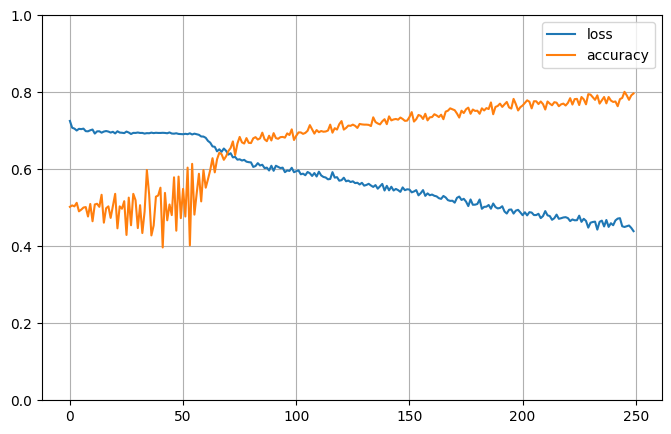


Testing # 1 1
2023-04-19 17:56:29.556914
2023-04-19 17:56:29.556964
PREDICT
2023-04-19 17:56:29.562737
Test 1:0 246:141 63.57%
Predict 1:0 239:148 61.76%
Test sizes (387, 1025) (387,)
Distrib of scores: 0.5845191 mean 0.307119 std
Range of scores: 0.005891228 to 0.99847215
Score threshold 0.5
Confusion matrix
 [[ 77  64]
 [ 71 175]]
Normalized matrix
 [[0.19896641 0.16537468]
 [0.18346253 0.45219638]]
Extreme scores correct, pos:neg 145 60
Extreme scores incorrect pos:neg 46 52


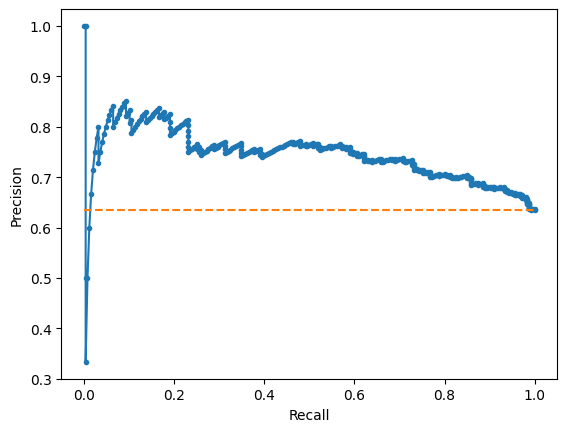

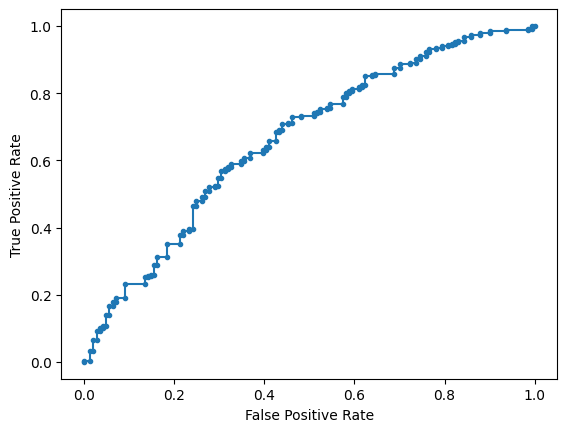

Accuracy: 65.12% Precision: 73.22% Recall: 71.14%
F1: 72.16% MCC: 0.2550
AUPRC: 74.46% AUROC: 66.18%
 accuracy [65.11627906976744]
 precision [73.22175732217573]
 recall [71.13821138211382]
 F1 [72.16494845360825]
 MCC [0.25497239965744417]
 AUPRC [74.45960735092589]
 AUROC [66.1765553825751]
 accuracy mean 65.12% std nan
 precision mean 73.22% std nan
 recall mean 71.14% std nan
 F1 mean 72.16% std nan
 MCC mean 0.2550 std nan
 AUPRC mean 74.46% std nan
 AUROC mean 66.18% std nan
 accuracy [[65.11627906976744]]
 precision [[73.22175732217573]]
 recall [[71.13821138211382]]
 F1 [[72.16494845360825]]
 MCC [[0.25497239965744417]]
 AUPRC [[74.45960735092589]]
 AUROC [[66.1765553825751]]

2023-04-19 17:56:30.207142
Cell Line 1 H1.hESC
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 2982
Num RCI: 2982
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.c

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 2982 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 728
Num RCI: 728
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 728 sequences.

Training # 1 1
2023-04-19 17:56:36.521854
2023-04-19 17:56:36.521920
Discriminator is GMM
Means [0.40146284378281777, -1.4482882755188413]
Variances [1.55005853 1.57888046]
Priors [0.56137863 0.43862137]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1768:1214 59.29%
Computed class weights: {0: 1.228171334431631, 1: 0.8433257918552036}
FIT
2023-04-19 17:56:40.665416


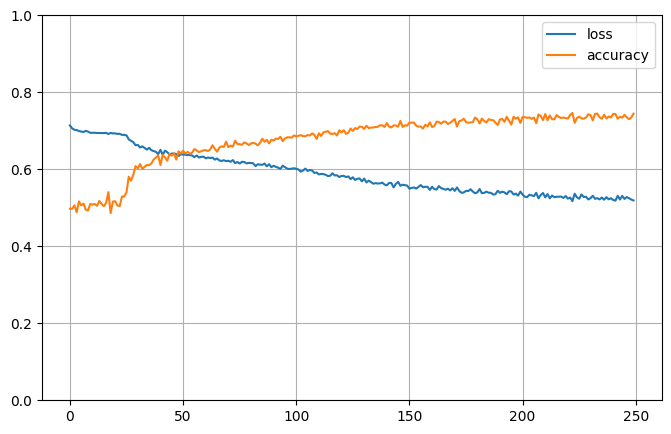


Testing # 1 1
2023-04-19 17:59:04.020735
2023-04-19 17:59:04.020786
PREDICT
2023-04-19 17:59:04.030615
Test 1:0 426:302 58.52%
Predict 1:0 439:289 60.30%
Test sizes (728, 1025) (728,)
Distrib of scores: 0.55644834 mean 0.26681817 std
Range of scores: 0.0018267758 to 0.9945641
Score threshold 0.5
Confusion matrix
 [[153 149]
 [136 290]]
Normalized matrix
 [[0.21016484 0.20467033]
 [0.18681319 0.39835165]]
Extreme scores correct, pos:neg 225 110
Extreme scores incorrect pos:neg 92 78


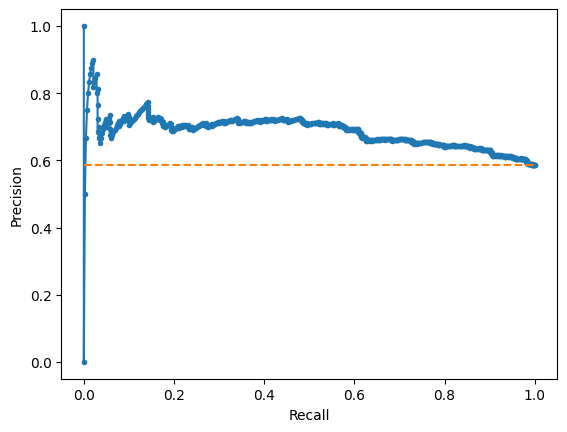

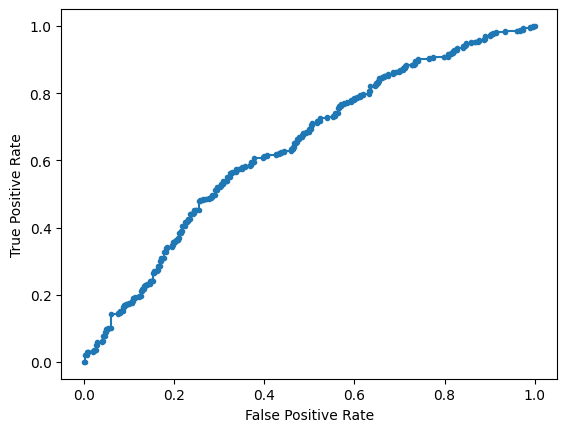

Accuracy: 60.85% Precision: 66.06% Recall: 68.08%
F1: 67.05% MCC: 0.1887
AUPRC: 68.55% AUROC: 64.01%
 accuracy [60.85164835164834]
 precision [66.05922551252847]
 recall [68.07511737089203]
 F1 [67.05202312138728]
 MCC [0.18868427163118345]
 AUPRC [68.55090346821129]
 AUROC [64.01144171874513]
 accuracy mean 60.85% std nan
 precision mean 66.06% std nan
 recall mean 68.08% std nan
 F1 mean 67.05% std nan
 MCC mean 0.1887 std nan
 AUPRC mean 68.55% std nan
 AUROC mean 64.01% std nan
 accuracy [[60.85164835164834]]
 precision [[66.05922551252847]]
 recall [[68.07511737089203]]
 F1 [[67.05202312138728]]
 MCC [[0.18868427163118345]]
 AUPRC [[68.55090346821129]]
 AUROC [[64.01144171874513]]

2023-04-19 17:59:04.647473
Cell Line 2 HeLa.S3
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1008
Num RCI: 1008
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 1008 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 239
Num RCI: 239
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 239 sequences.

Training # 1 1
2023-04-19 17:59:06.912697
2023-04-19 17:59:06.912767
Discriminator is GMM
Means [-0.4164065766455784, -2.818421831978961]
Variances [1.90070251 2.04342939]
Priors [0.53260615 0.46739385]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 556:452 55.16%
Computed class weights: {0: 1.1150442477876106, 1: 0.9064748201438849}
FIT
2023-04-19 17:59:07.696328


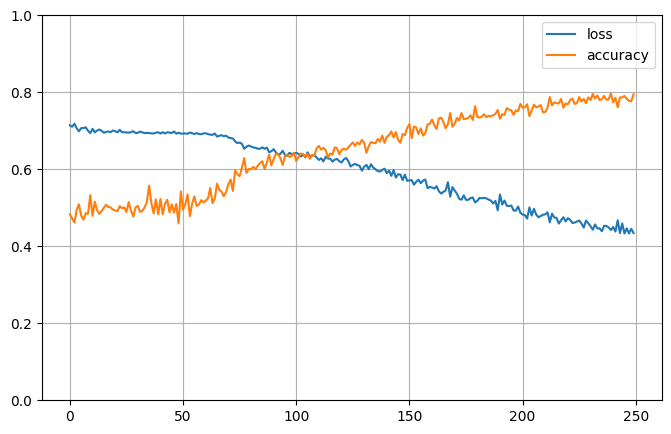


Testing # 1 1
2023-04-19 17:59:52.104086
2023-04-19 17:59:52.104130
PREDICT
2023-04-19 17:59:52.106102
Test 1:0 115:124 48.12%
Predict 1:0 119:120 49.79%
Test sizes (239, 1025) (239,)
Distrib of scores: 0.46842894 mean 0.30375257 std
Range of scores: 0.006799386 to 0.98721695
Score threshold 0.5
Confusion matrix
 [[70 54]
 [50 65]]
Normalized matrix
 [[0.29288703 0.22594142]
 [0.20920502 0.27196653]]
Extreme scores correct, pos:neg 44 65
Extreme scores incorrect pos:neg 40 37


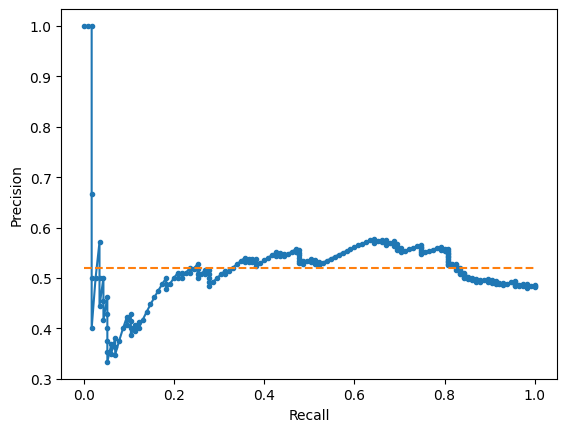

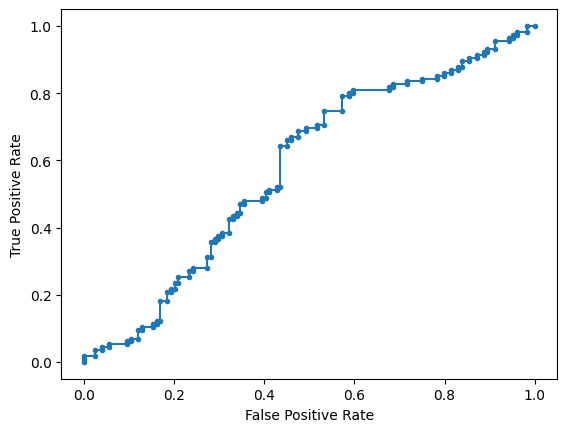

Accuracy: 56.49% Precision: 54.62% Recall: 56.52%
F1: 55.56% MCC: 0.1296
AUPRC: 52.10% AUROC: 57.68%
 accuracy [56.48535564853556]
 precision [54.621848739495796]
 recall [56.52173913043478]
 F1 [55.55555555555555]
 MCC [0.12964263869999756]
 AUPRC [52.10437721582926]
 AUROC [57.678821879382895]
 accuracy mean 56.49% std nan
 precision mean 54.62% std nan
 recall mean 56.52% std nan
 F1 mean 55.56% std nan
 MCC mean 0.1296 std nan
 AUPRC mean 52.10% std nan
 AUROC mean 57.68% std nan
 accuracy [[56.48535564853556]]
 precision [[54.621848739495796]]
 recall [[56.52173913043478]]
 F1 [[55.55555555555555]]
 MCC [[0.12964263869999756]]
 AUPRC [[52.10437721582926]]
 AUROC [[57.678821879382895]]

2023-04-19 17:59:52.883421
Cell Line 3 HepG2
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1516
Num RCI: 1516
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/tra

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 1516 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 383
Num RCI: 383
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 383 sequences.

Training # 1 1
2023-04-19 17:59:58.565761
2023-04-19 17:59:58.565829
Discriminator is GMM
Means [-3.0277815228385685, -0.20664239362691122]
Variances [2.56504726 1.66709545]
Priors [0.42795125 0.57204875]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 915:601 60.36%
Computed class weights: {0: 1.2612312811980033, 1: 0.8284153005464481}
FIT
2023-04-19 17:59:59.351970


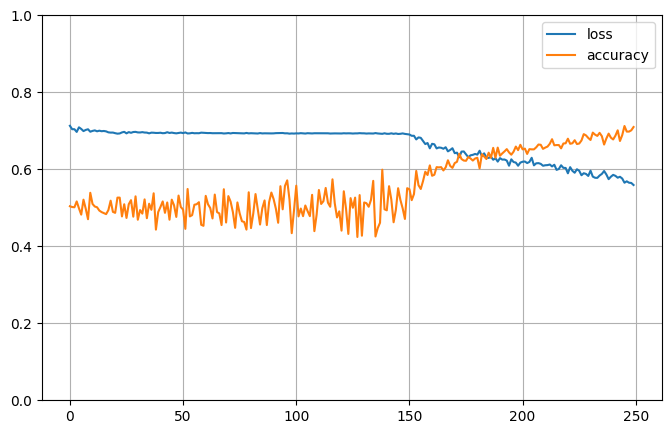


Testing # 1 1
2023-04-19 18:01:03.633381
2023-04-19 18:01:03.633428
PREDICT
2023-04-19 18:01:03.638456
Test 1:0 226:157 59.01%
Predict 1:0 242:141 63.19%
Test sizes (383, 1025) (383,)
Distrib of scores: 0.56681156 mean 0.21336715 std
Range of scores: 0.039002676 to 0.94557214
Score threshold 0.5
Confusion matrix
 [[ 76  81]
 [ 65 161]]
Normalized matrix
 [[0.19843342 0.21148825]
 [0.16971279 0.42036554]]
Extreme scores correct, pos:neg 113 41
Extreme scores incorrect pos:neg 38 30


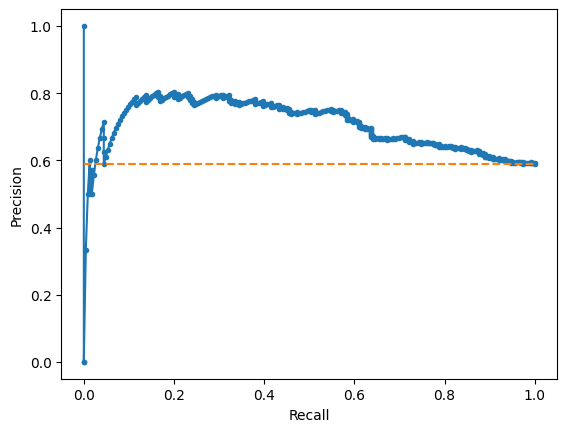

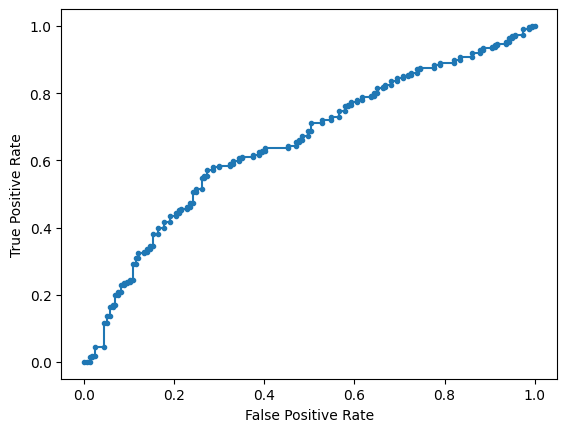

Accuracy: 61.88% Precision: 66.53% Recall: 71.24%
F1: 68.80% MCC: 0.2003
AUPRC: 70.26% AUROC: 65.10%
 accuracy [61.8798955613577]
 precision [66.52892561983471]
 recall [71.23893805309734]
 F1 [68.80341880341881]
 MCC [0.20034282695902425]
 AUPRC [70.26014733237312]
 AUROC [65.10061439603179]
 accuracy mean 61.88% std nan
 precision mean 66.53% std nan
 recall mean 71.24% std nan
 F1 mean 68.80% std nan
 MCC mean 0.2003 std nan
 AUPRC mean 70.26% std nan
 AUROC mean 65.10% std nan
 accuracy [[61.8798955613577]]
 precision [[66.52892561983471]]
 recall [[71.23893805309734]]
 F1 [[68.80341880341881]]
 MCC [[0.20034282695902425]]
 AUPRC [[70.26014733237312]]
 AUROC [[65.10061439603179]]

2023-04-19 18:01:04.505752
Cell Line 4 HT1080
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1025
Num RCI: 1025
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.ca

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 1025 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 262
Num RCI: 262
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 262 sequences.

Training # 1 1
2023-04-19 18:01:09.503914
2023-04-19 18:01:09.503979
Discriminator is GMM
Means [0.41825457993226073, -2.151948974499462]
Variances [1.31883278 2.80568508]
Priors [0.61412702 0.38587298]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 686:339 66.93%
Computed class weights: {0: 1.5117994100294985, 1: 0.7470845481049563}
FIT
2023-04-19 18:01:10.295805


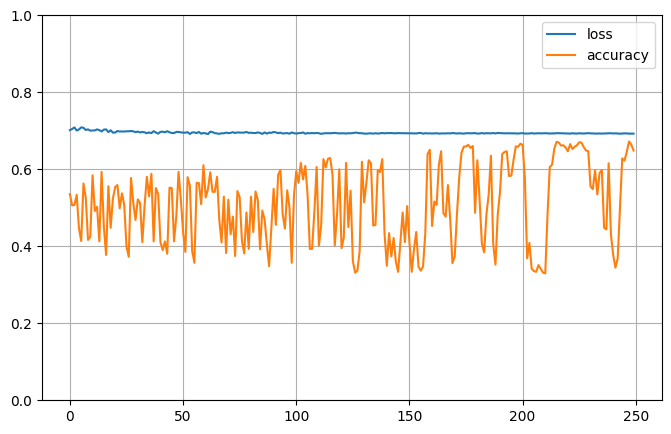


Testing # 1 1
2023-04-19 18:02:33.671250
2023-04-19 18:02:33.671297
PREDICT
2023-04-19 18:02:33.675862
Test 1:0 177:85 67.56%
Predict 1:0 262:0 100.00%
Test sizes (262, 1025) (262,)
Distrib of scores: 0.5171793 mean 0.0013803215 std
Range of scores: 0.5134474 to 0.52322394
Score threshold 0.5
Confusion matrix
 [[  0  85]
 [  0 177]]
Normalized matrix
 [[0.         0.32442748]
 [0.         0.67557252]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


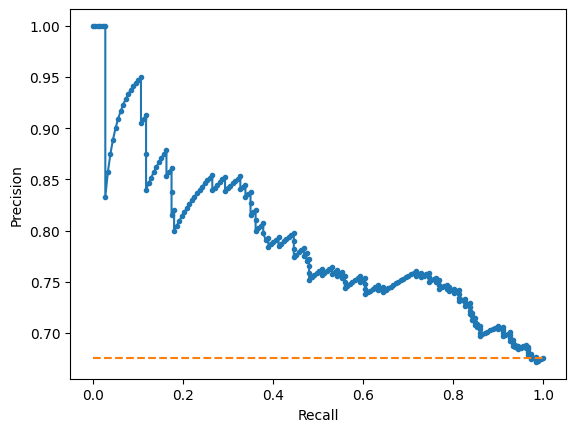

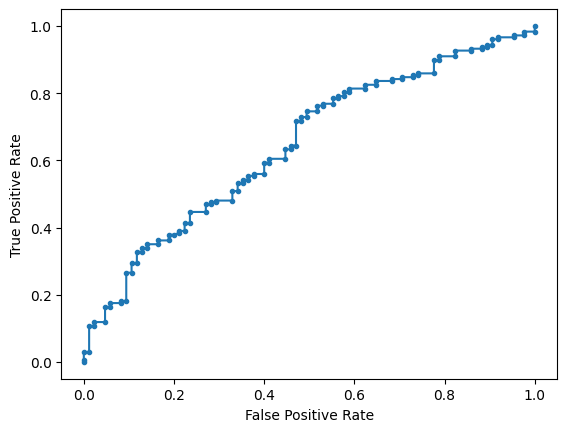

Accuracy: 67.56% Precision: 67.56% Recall: 100.00%
F1: 80.64% MCC: 0.0000
AUPRC: 78.94% AUROC: 64.57%
 accuracy [67.55725190839695]
 precision [67.55725190839695]
 recall [100.0]
 F1 [80.6378132118451]
 MCC [0.0]
 AUPRC [78.93777565142909]
 AUROC [64.56962445995347]
 accuracy mean 67.56% std nan
 precision mean 67.56% std nan
 recall mean 100.00% std nan
 F1 mean 80.64% std nan
 MCC mean 0.0000 std nan
 AUPRC mean 78.94% std nan
 AUROC mean 64.57% std nan
 accuracy [[67.55725190839695]]
 precision [[67.55725190839695]]
 recall [[100.0]]
 F1 [[80.6378132118451]]
 MCC [[0.0]]
 AUPRC [[78.93777565142909]]
 AUROC [[64.56962445995347]]

2023-04-19 18:02:34.266914
Cell Line 5 HUVEC
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1680
Num RCI: 1680
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv


/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 1680 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 408
Num RCI: 408
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 408 sequences.

Training # 1 1
2023-04-19 18:02:38.088966
2023-04-19 18:02:38.089038
Discriminator is GMM
Means [-3.1148435538351538, -0.13561061104225194]
Variances [2.52809231 1.89858956]
Priors [0.42169953 0.57830047]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 1027:653 61.13%
Computed class weights: {0: 1.2863705972434916, 1: 0.8179162609542356}
FIT
2023-04-19 18:02:38.941048


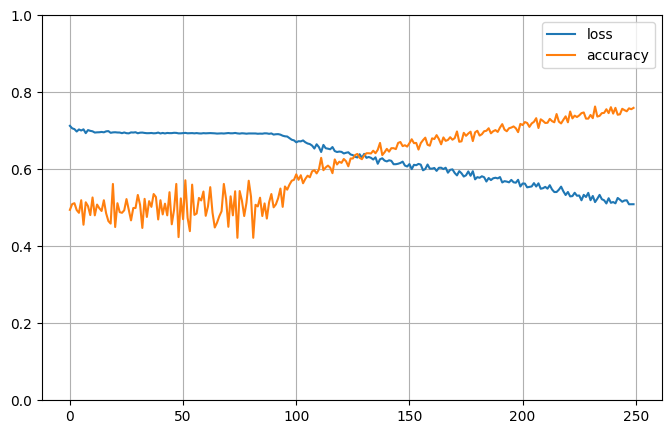


Testing # 1 1
2023-04-19 18:03:51.206440
2023-04-19 18:03:51.206895
PREDICT
2023-04-19 18:03:51.210276
Test 1:0 243:165 59.56%
Predict 1:0 246:162 60.29%
Test sizes (408, 1025) (408,)
Distrib of scores: 0.5400739 mean 0.25313017 std
Range of scores: 0.0007720438 to 0.9535248
Score threshold 0.5
Confusion matrix
 [[ 89  76]
 [ 73 170]]
Normalized matrix
 [[0.21813725 0.18627451]
 [0.17892157 0.41666667]]
Extreme scores correct, pos:neg 111 59
Extreme scores incorrect pos:neg 50 39


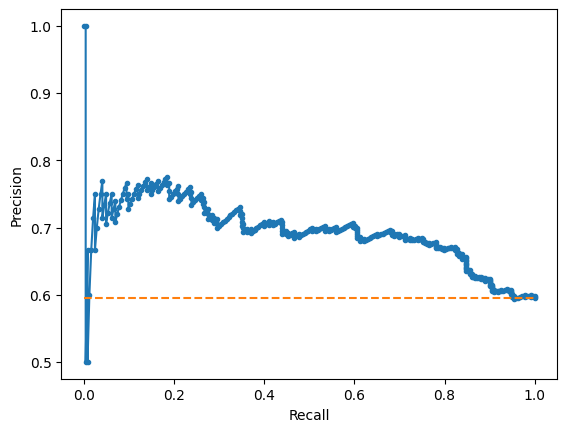

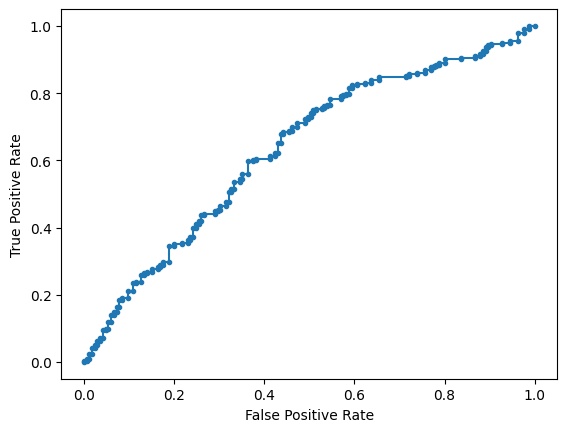

Accuracy: 63.48% Precision: 69.11% Recall: 69.96%
F1: 69.53% MCC: 0.2397
AUPRC: 69.36% AUROC: 63.44%
 accuracy [63.48039215686274]
 precision [69.10569105691057]
 recall [69.95884773662551]
 F1 [69.52965235173824]
 MCC [0.23970991438446004]
 AUPRC [69.36241805265566]
 AUROC [63.43683751091158]
 accuracy mean 63.48% std nan
 precision mean 69.11% std nan
 recall mean 69.96% std nan
 F1 mean 69.53% std nan
 MCC mean 0.2397 std nan
 AUPRC mean 69.36% std nan
 AUROC mean 63.44% std nan
 accuracy [[63.48039215686274]]
 precision [[69.10569105691057]]
 recall [[69.95884773662551]]
 F1 [[69.52965235173824]]
 MCC [[0.23970991438446004]]
 AUPRC [[69.36241805265566]]
 AUROC [[63.43683751091158]]

2023-04-19 18:03:52.129306
Cell Line 6 MCF.7
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 2361
Num RCI: 2361
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.c

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 2361 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 588
Num RCI: 588
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 588 sequences.

Training # 1 1
2023-04-19 18:03:58.134299
2023-04-19 18:03:58.134384
Discriminator is GMM
Means [-0.1445817540767038, -3.2669503183780497]
Variances [2.19280847 2.62061738]
Priors [0.53920825 0.46079175]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 1308:1053 55.40%
Computed class weights: {0: 1.121082621082621, 1: 0.9025229357798165}
FIT
2023-04-19 18:03:59.226521


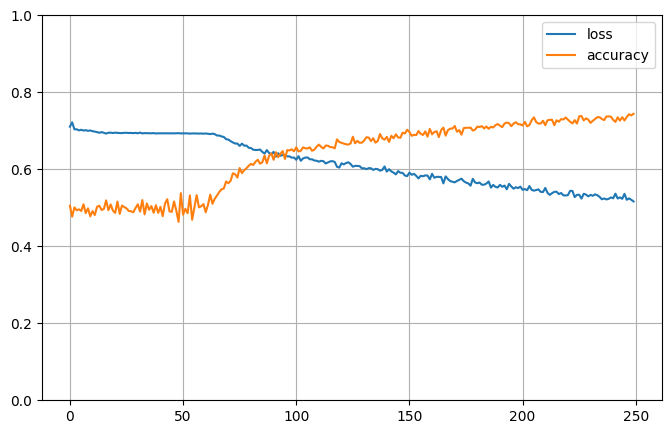


Testing # 1 1
2023-04-19 18:06:23.371732
2023-04-19 18:06:23.371782
PREDICT
2023-04-19 18:06:23.378699
Test 1:0 344:244 58.50%
Predict 1:0 378:210 64.29%
Test sizes (588, 1025) (588,)
Distrib of scores: 0.5695962 mean 0.24028634 std
Range of scores: 0.008019141 to 0.96290064
Score threshold 0.5
Confusion matrix
 [[118 126]
 [ 92 252]]
Normalized matrix
 [[0.20068027 0.21428571]
 [0.15646259 0.42857143]]
Extreme scores correct, pos:neg 185 64
Extreme scores incorrect pos:neg 81 49


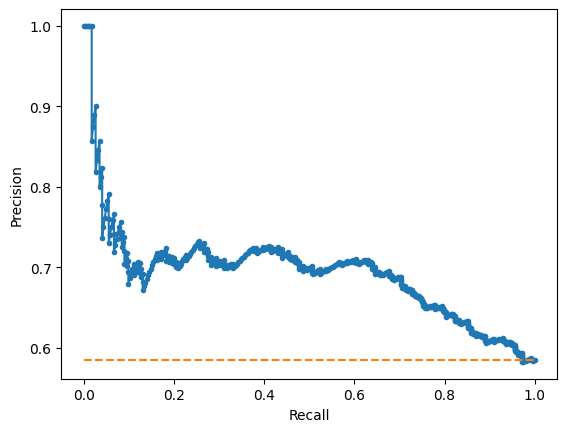

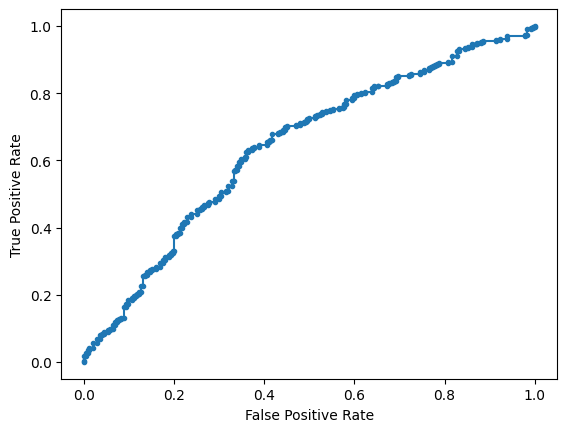

Accuracy: 62.93% Precision: 66.67% Recall: 73.26%
F1: 69.81% MCC: 0.2223
AUPRC: 69.38% AUROC: 64.04%
 accuracy [62.925170068027214]
 precision [66.66666666666666]
 recall [73.25581395348837]
 F1 [69.80609418282549]
 MCC [0.22228151875464228]
 AUPRC [69.37639393726651]
 AUROC [64.03926801372475]
 accuracy mean 62.93% std nan
 precision mean 66.67% std nan
 recall mean 73.26% std nan
 F1 mean 69.81% std nan
 MCC mean 0.2223 std nan
 AUPRC mean 69.38% std nan
 AUROC mean 64.04% std nan
 accuracy [[62.925170068027214]]
 precision [[66.66666666666666]]
 recall [[73.25581395348837]]
 F1 [[69.80609418282549]]
 MCC [[0.22228151875464228]]
 AUPRC [[69.37639393726651]]
 AUROC [[64.03926801372475]]

2023-04-19 18:06:24.306506
Cell Line 7 NCI.H460
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 695
Num RCI: 695
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/trai

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 695 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 165
Num RCI: 165
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 165 sequences.

Training # 1 1
2023-04-19 18:06:27.254460
2023-04-19 18:06:27.254775
Discriminator is GMM
Means [-0.7499228329865164, -3.0108672255506024]
Variances [2.1853445  3.12369922]
Priors [0.67868669 0.32131331]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
Train 1:0 539:156 77.55%
Computed class weights: {0: 2.2275641025641026, 1: 0.6447124304267161}
FIT
2023-04-19 18:06:28.047593


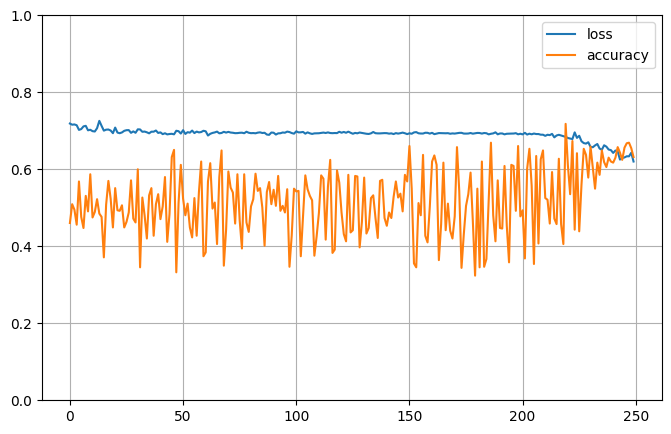


Testing # 1 1
2023-04-19 18:07:10.503168
2023-04-19 18:07:10.503225
PREDICT
2023-04-19 18:07:10.505168
Test 1:0 120:45 72.73%
Predict 1:0 118:47 71.52%
Test sizes (165, 1025) (165,)
Distrib of scores: 0.5714997 mean 0.111702956 std
Range of scores: 0.2595981 to 0.8007366
Score threshold 0.5
Confusion matrix
 [[16 29]
 [31 89]]
Normalized matrix
 [[0.0969697  0.17575758]
 [0.18787879 0.53939394]]
Extreme scores correct, pos:neg 44 3
Extreme scores incorrect pos:neg 10 4


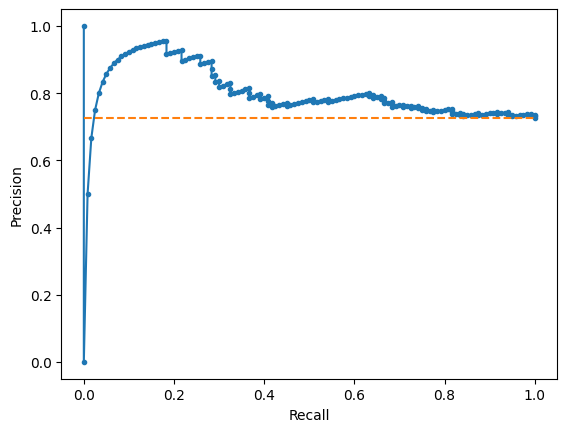

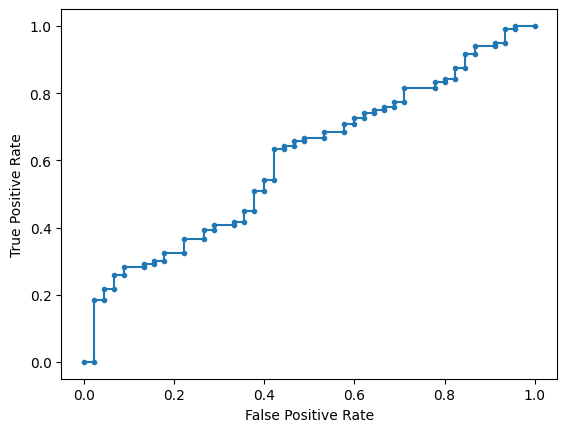

Accuracy: 63.64% Precision: 75.42% Recall: 74.17%
F1: 74.79% MCC: 0.0959
AUPRC: 79.83% AUROC: 60.35%
 accuracy [63.63636363636363]
 precision [75.42372881355932]
 recall [74.16666666666667]
 F1 [74.78991596638657]
 MCC [0.09593398629855149]
 AUPRC [79.82908471707044]
 AUROC [60.351851851851855]
 accuracy mean 63.64% std nan
 precision mean 75.42% std nan
 recall mean 74.17% std nan
 F1 mean 74.79% std nan
 MCC mean 0.0959 std nan
 AUPRC mean 79.83% std nan
 AUROC mean 60.35% std nan
 accuracy [[63.63636363636363]]
 precision [[75.42372881355932]]
 recall [[74.16666666666667]]
 F1 [[74.78991596638657]]
 MCC [[0.09593398629855149]]
 AUPRC [[79.82908471707044]]
 AUROC [[60.351851851851855]]

2023-04-19 18:07:11.108748
Cell Line 8 NHEK
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1208
Num RCI: 1208
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 1208 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 288
Num RCI: 288
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 288 sequences.

Training # 1 1
2023-04-19 18:07:14.105679
2023-04-19 18:07:14.105771
Discriminator is GMM
Means [-0.18715450950521162, -2.9218121124567493]
Variances [1.59780369 3.1629524 ]
Priors [0.63329397 0.36670603]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 833:375 68.96%
Computed class weights: {0: 1.6106666666666667, 1: 0.7250900360144058}
FIT
2023-04-19 18:07:15.013098


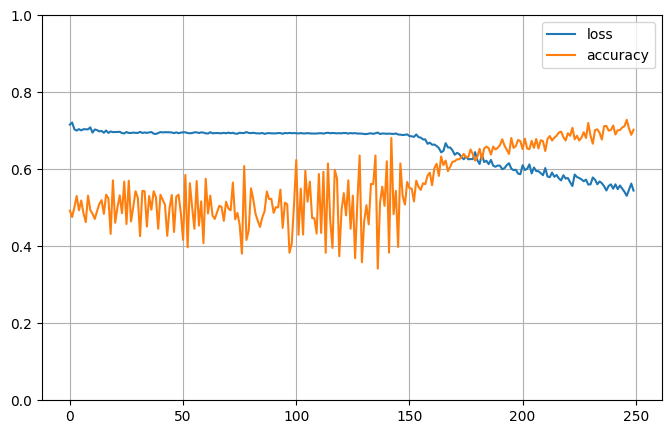


Testing # 1 1
2023-04-19 18:08:38.461779
2023-04-19 18:08:38.461841
PREDICT
2023-04-19 18:08:38.470542
Test 1:0 193:95 67.01%
Predict 1:0 208:80 72.22%
Test sizes (288, 1025) (288,)
Distrib of scores: 0.6300297 mean 0.2076202 std
Range of scores: 0.111895636 to 0.9871518
Score threshold 0.5
Confusion matrix
 [[ 39  56]
 [ 41 152]]
Normalized matrix
 [[0.13541667 0.19444444]
 [0.14236111 0.52777778]]
Extreme scores correct, pos:neg 117 19
Extreme scores incorrect pos:neg 34 17


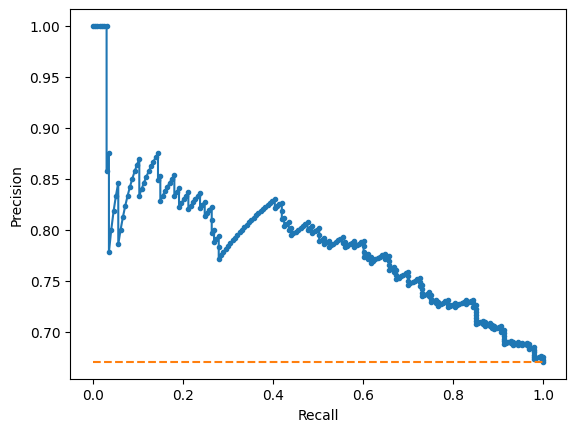

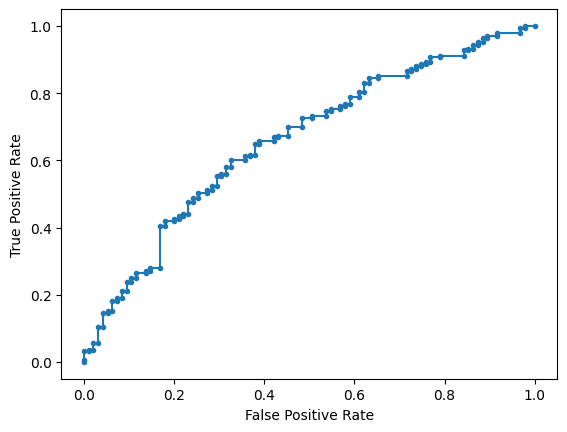

Accuracy: 66.32% Precision: 73.08% Recall: 78.76%
F1: 75.81% MCC: 0.2079
AUPRC: 78.49% AUROC: 65.99%
 accuracy [66.31944444444444]
 precision [73.07692307692307]
 recall [78.75647668393782]
 F1 [75.81047381546135]
 MCC [0.20793553863551956]
 AUPRC [78.48797332815755]
 AUROC [65.99400054540496]
 accuracy mean 66.32% std nan
 precision mean 73.08% std nan
 recall mean 78.76% std nan
 F1 mean 75.81% std nan
 MCC mean 0.2079 std nan
 AUPRC mean 78.49% std nan
 AUROC mean 65.99% std nan
 accuracy [[66.31944444444444]]
 precision [[73.07692307692307]]
 recall [[78.75647668393782]]
 F1 [[75.81047381546135]]
 MCC [[0.20793553863551956]]
 AUPRC [[78.48797332815755]]
 AUROC [[65.99400054540496]]

2023-04-19 18:08:39.210732
Cell Line 9 SK.MEL.5
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 605
Num RCI: 605
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 605 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 158
Num RCI: 158
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 158 sequences.

Training # 1 1
2023-04-19 18:08:43.033268
2023-04-19 18:08:43.033395
Discriminator is GMM
Means [-3.641821507007351, -0.7005275969105765]
Variances [3.84438107 2.28787762]
Priors [0.37187687 0.62812313]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
Train 1:0 422:183 69.75%
Computed class weights: {0: 1.6530054644808743, 1: 0.716824644549763}
FIT
2023-04-19 18:08:44.154169


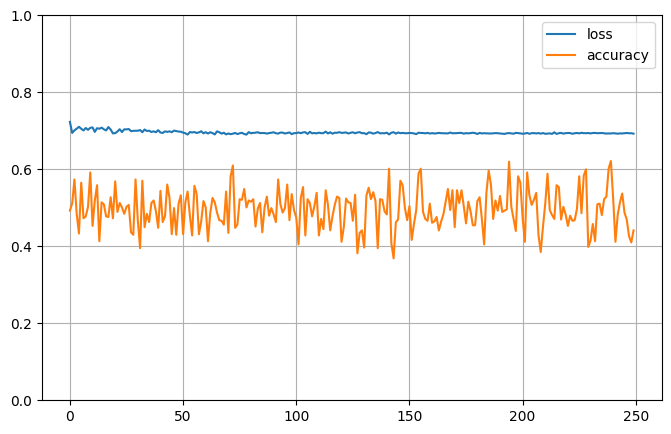


Testing # 1 1
2023-04-19 18:09:12.480496
2023-04-19 18:09:12.480565
PREDICT
2023-04-19 18:09:12.482218
Test 1:0 112:46 70.89%
Predict 1:0 0:158  0.00%
Test sizes (158, 1025) (158,)
Distrib of scores: 0.49681404 mean 0.00030096696 std
Range of scores: 0.49603352 to 0.49804458
Score threshold 0.5
Confusion matrix
 [[ 46   0]
 [112   0]]
Normalized matrix
 [[0.29113924 0.        ]
 [0.70886076 0.        ]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


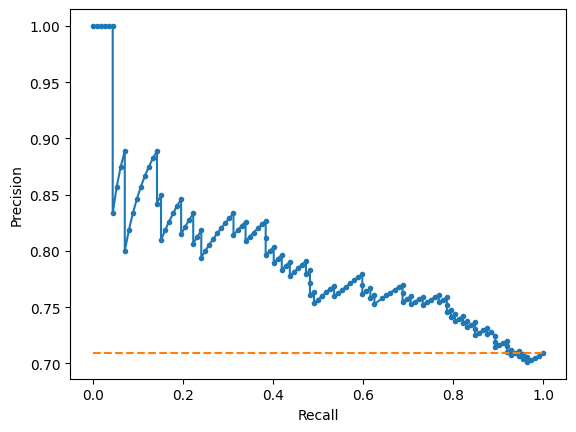

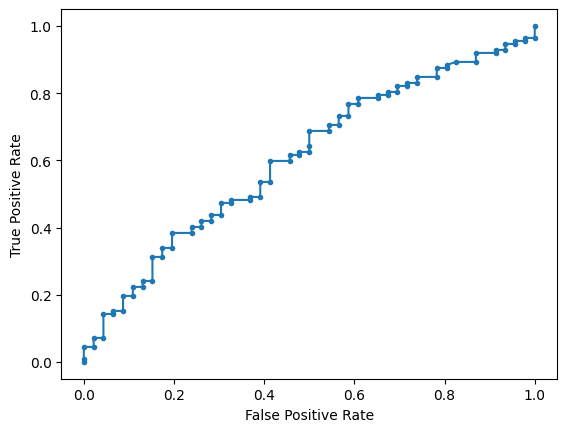

Accuracy: 29.11% Precision: 0.00% Recall: 0.00%
F1: 0.00% MCC: 0.0000
AUPRC: 79.00% AUROC: 60.72%
 accuracy [29.11392405063291]
 precision [0.0]
 recall [0.0]
 F1 [0.0]
 MCC [0.0]
 AUPRC [79.00116296071037]
 AUROC [60.723990683229815]
 accuracy mean 29.11% std nan
 precision mean 0.00% std nan
 recall mean 0.00% std nan
 F1 mean 0.00% std nan
 MCC mean 0.0000 std nan
 AUPRC mean 79.00% std nan
 AUROC mean 60.72% std nan
 accuracy [[29.11392405063291]]
 precision [[0.0]]
 recall [[0.0]]
 F1 [[0.0]]
 MCC [[0.0]]
 AUPRC [[79.00116296071037]]
 AUROC [[60.723990683229815]]

2023-04-19 18:09:13.134053
Cell Line 10 SK.N.DZ
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 677
Num RCI: 677
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv


/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 677 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 170
Num RCI: 170
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 170 sequences.

Training # 1 1
2023-04-19 18:09:15.402029
2023-04-19 18:09:15.402105
Discriminator is GMM
Means [0.019638573421281558, -2.102332474894561]
Variances [1.11014878 2.56586809]
Priors [0.70582437 0.29417563]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 540:137 79.76%
Computed class weights: {0: 2.4708029197080292, 1: 0.6268518518518519}
FIT
2023-04-19 18:09:16.189199


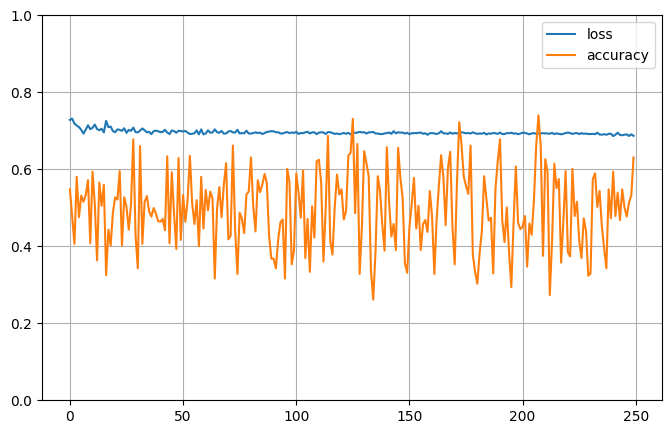


Testing # 1 1
2023-04-19 18:09:47.625840
2023-04-19 18:09:47.625901
PREDICT
2023-04-19 18:09:47.627595
Test 1:0 128:42 75.29%
Predict 1:0 26:144 15.29%
Test sizes (170, 1025) (170,)
Distrib of scores: 0.4859228 mean 0.014073211 std
Range of scores: 0.450053 to 0.52084476
Score threshold 0.5
Confusion matrix
 [[ 39   3]
 [105  23]]
Normalized matrix
 [[0.22941176 0.01764706]
 [0.61764706 0.13529412]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


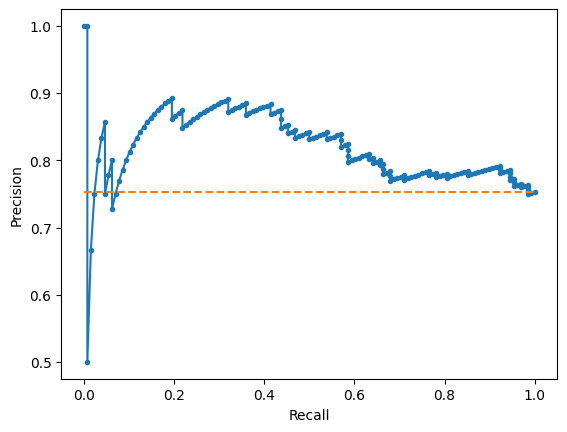

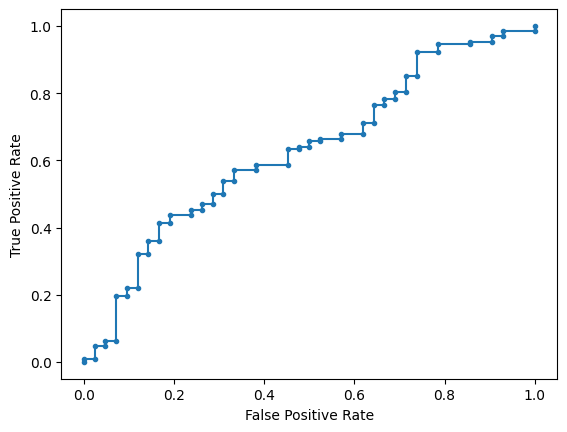

Accuracy: 36.47% Precision: 88.46% Recall: 17.97%
F1: 29.87% MCC: 0.1297
AUPRC: 81.96% AUROC: 62.85%
 accuracy [36.470588235294116]
 precision [88.46153846153845]
 recall [17.96875]
 F1 [29.870129870129876]
 MCC [0.12972552429237047]
 AUPRC [81.95578332602493]
 AUROC [62.85342261904761]
 accuracy mean 36.47% std nan
 precision mean 88.46% std nan
 recall mean 17.97% std nan
 F1 mean 29.87% std nan
 MCC mean 0.1297 std nan
 AUPRC mean 81.96% std nan
 AUROC mean 62.85% std nan
 accuracy [[36.470588235294116]]
 precision [[88.46153846153845]]
 recall [[17.96875]]
 F1 [[29.870129870129876]]
 MCC [[0.12972552429237047]]
 AUPRC [[81.95578332602493]]
 AUROC [[62.85342261904761]]

2023-04-19 18:09:48.208799
Cell Line 11 SK.N.SH
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1819
Num RCI: 1819
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 1819 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 471
Num RCI: 471
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 471 sequences.

Training # 1 1
2023-04-19 18:09:54.546132
2023-04-19 18:09:54.546218
Discriminator is GMM
Means [-3.110502675077478, -0.1125226175752773]
Variances [2.93675041 2.05941152]
Priors [0.4263897 0.5736103]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 1099:720 60.42%
Computed class weights: {0: 1.2631944444444445, 1: 0.8275705186533212}
FIT
2023-04-19 18:09:55.812283


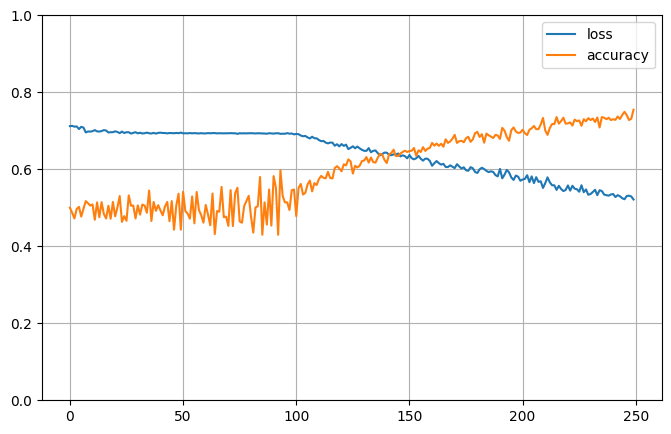


Testing # 1 1
2023-04-19 18:11:16.026401
2023-04-19 18:11:16.028455
PREDICT
2023-04-19 18:11:16.037542
Test 1:0 287:184 60.93%
Predict 1:0 288:183 61.15%
Test sizes (471, 1025) (471,)
Distrib of scores: 0.5501816 mean 0.24758707 std
Range of scores: 0.004290964 to 0.96781164
Score threshold 0.5
Confusion matrix
 [[ 90  94]
 [ 93 194]]
Normalized matrix
 [[0.1910828  0.19957537]
 [0.19745223 0.4118896 ]]
Extreme scores correct, pos:neg 145 64
Extreme scores incorrect pos:neg 47 46


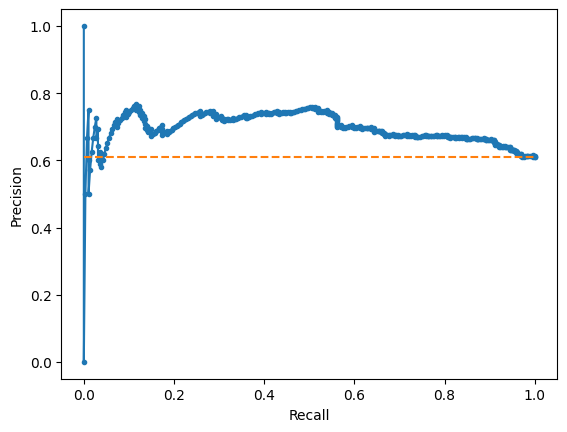

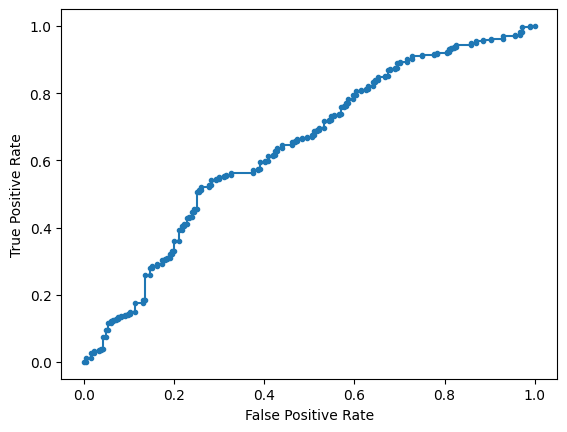

Accuracy: 60.30% Precision: 67.36% Recall: 67.60%
F1: 67.48% MCC: 0.1653
AUPRC: 69.55% AUROC: 63.92%
 accuracy [60.29723991507431]
 precision [67.36111111111111]
 recall [67.59581881533101]
 F1 [67.47826086956522]
 MCC [0.1652514260931117]
 AUPRC [69.55123102855161]
 AUROC [63.92402666262688]
 accuracy mean 60.30% std nan
 precision mean 67.36% std nan
 recall mean 67.60% std nan
 F1 mean 67.48% std nan
 MCC mean 0.1653 std nan
 AUPRC mean 69.55% std nan
 AUROC mean 63.92% std nan
 accuracy [[60.29723991507431]]
 precision [[67.36111111111111]]
 recall [[67.59581881533101]]
 F1 [[67.47826086956522]]
 MCC [[0.1652514260931117]]
 AUPRC [[69.55123102855161]]
 AUROC [[63.92402666262688]]

2023-04-19 18:11:16.962132
Cell Line 12 GM12878
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1905
Num RCI: 1905
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 1905 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 473
Num RCI: 473
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 473 sequences.

Training # 1 1
2023-04-19 18:11:23.197474
2023-04-19 18:11:23.197571
Discriminator is GMM
Means [-0.29013189403629913, -2.3434539157930314]
Variances [1.26135704 2.16066452]
Priors [0.57998355 0.42001645]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 1205:700 63.25%
Computed class weights: {0: 1.3607142857142858, 1: 0.7904564315352697}
FIT
2023-04-19 18:11:24.277728


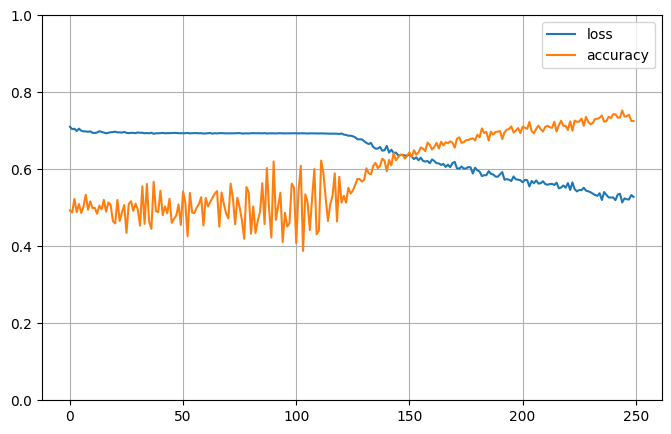


Testing # 1 1
2023-04-19 18:12:45.774477
2023-04-19 18:12:45.774538
PREDICT
2023-04-19 18:12:45.782322
Test 1:0 293:180 61.95%
Predict 1:0 249:224 52.64%
Test sizes (473, 1025) (473,)
Distrib of scores: 0.5118884 mean 0.25119027 std
Range of scores: 0.0054345024 to 0.9761756
Score threshold 0.5
Confusion matrix
 [[116  64]
 [108 185]]
Normalized matrix
 [[0.24524313 0.13530655]
 [0.22832981 0.39112051]]
Extreme scores correct, pos:neg 125 84
Extreme scores incorrect pos:neg 41 63


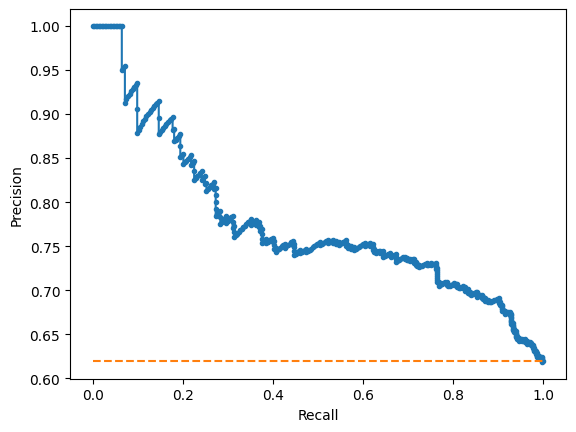

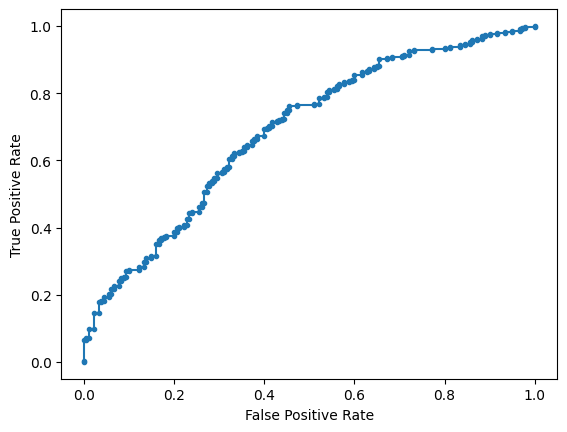

Accuracy: 63.64% Precision: 74.30% Recall: 63.14%
F1: 68.27% MCC: 0.2682
AUPRC: 77.62% AUROC: 68.78%
 accuracy [63.63636363636363]
 precision [74.29718875502009]
 recall [63.13993174061433]
 F1 [68.26568265682657]
 MCC [0.268231357129257]
 AUPRC [77.62347198091643]
 AUROC [68.77891543420553]
 accuracy mean 63.64% std nan
 precision mean 74.30% std nan
 recall mean 63.14% std nan
 F1 mean 68.27% std nan
 MCC mean 0.2682 std nan
 AUPRC mean 77.62% std nan
 AUROC mean 68.78% std nan
 accuracy [[63.63636363636363]]
 precision [[74.29718875502009]]
 recall [[63.13993174061433]]
 F1 [[68.26568265682657]]
 MCC [[0.268231357129257]]
 AUPRC [[77.62347198091643]]
 AUROC [[68.77891543420553]]

2023-04-19 18:12:46.399991
Cell Line 13 K562
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1040
Num RCI: 1040
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 1040 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 293
Num RCI: 293
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 293 sequences.

Training # 1 1
2023-04-19 18:12:48.901976
2023-04-19 18:12:48.902044
Discriminator is GMM
Means [-0.15509047641157286, -2.542607097137772]
Variances [1.3992858  1.69215773]
Priors [0.64873974 0.35126026]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 708:332 68.08%
Computed class weights: {0: 1.5662650602409638, 1: 0.7344632768361582}
FIT
2023-04-19 18:12:49.766860


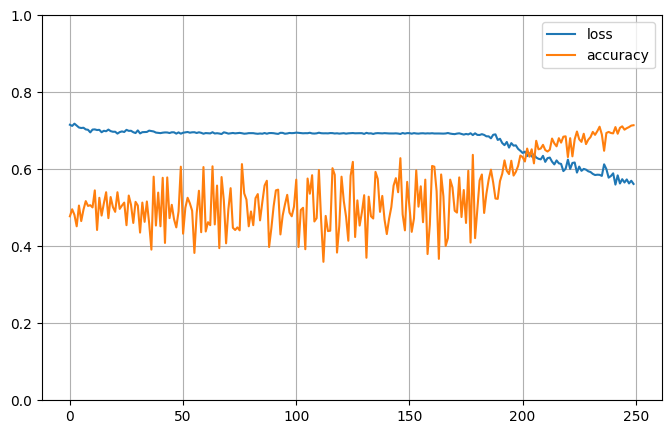


Testing # 1 1
2023-04-19 18:14:13.051025
2023-04-19 18:14:13.051078
PREDICT
2023-04-19 18:14:13.058410
Test 1:0 202:91 68.94%
Predict 1:0 132:161 45.05%
Test sizes (293, 1025) (293,)
Distrib of scores: 0.4844609 mean 0.19625515 std
Range of scores: 0.045698978 to 0.9265722
Score threshold 0.5
Confusion matrix
 [[ 66  25]
 [ 95 107]]
Normalized matrix
 [[0.22525597 0.08532423]
 [0.32423208 0.36518771]]
Extreme scores correct, pos:neg 56 35
Extreme scores incorrect pos:neg 10 42


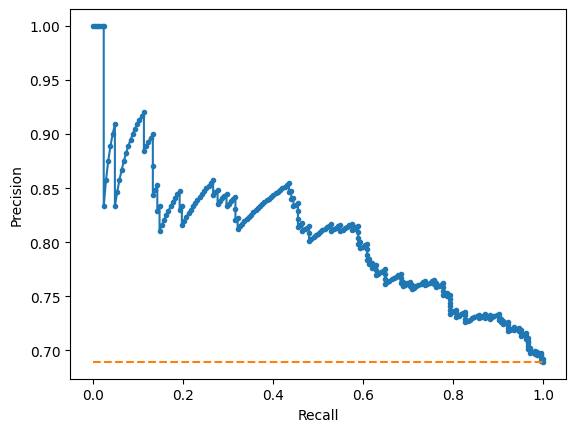

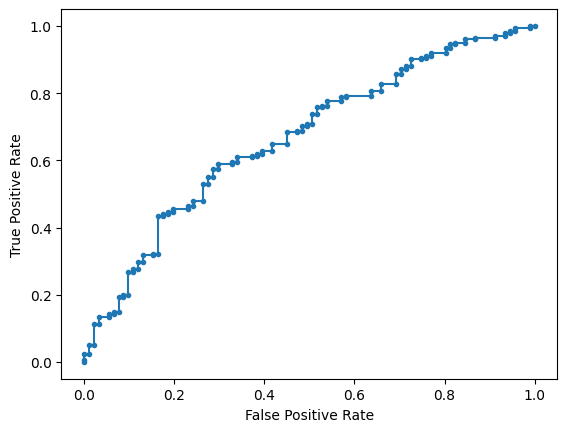

Accuracy: 59.04% Precision: 81.06% Recall: 52.97%
F1: 64.07% MCC: 0.2371
AUPRC: 80.50% AUROC: 66.67%
 accuracy [59.044368600682596]
 precision [81.06060606060606]
 recall [52.97029702970298]
 F1 [64.07185628742515]
 MCC [0.23713664381227056]
 AUPRC [80.50366094912604]
 AUROC [66.66848003481667]
 accuracy mean 59.04% std nan
 precision mean 81.06% std nan
 recall mean 52.97% std nan
 F1 mean 64.07% std nan
 MCC mean 0.2371 std nan
 AUPRC mean 80.50% std nan
 AUROC mean 66.67% std nan
 accuracy [[59.044368600682596]]
 precision [[81.06060606060606]]
 recall [[52.97029702970298]]
 F1 [[64.07185628742515]]
 MCC [[0.23713664381227056]]
 AUPRC [[80.50366094912604]]
 AUROC [[66.66848003481667]]

2023-04-19 18:14:14.208897
Cell Line 14 IMR.90
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 441
Num RCI: 441
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 441 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 108
Num RCI: 108
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 108 sequences.

Training # 1 1
2023-04-19 18:14:15.473366
2023-04-19 18:14:15.473605
Discriminator is GMM
Means [-2.637371770764905, 0.5571993348107099]
Variances [3.26957451 1.43718009]
Priors [0.39929755 0.60070245]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 282:159 63.95%
Computed class weights: {0: 1.3867924528301887, 1: 0.7819148936170213}
FIT
2023-04-19 18:14:16.042062


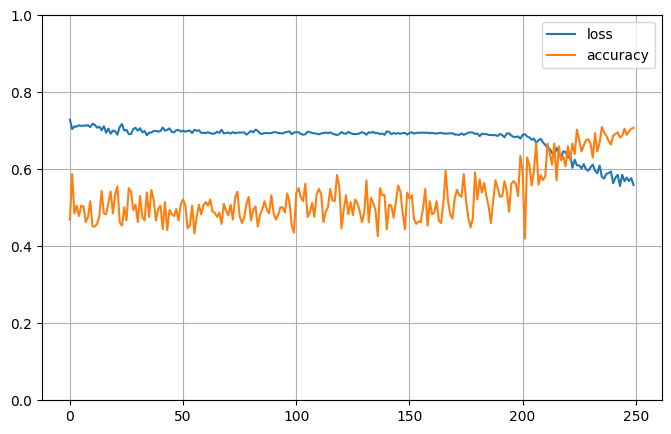


Testing # 1 1
2023-04-19 18:14:38.395836
2023-04-19 18:14:38.396267
PREDICT
2023-04-19 18:14:38.398827
Test 1:0 68:40 62.96%
Predict 1:0 50:58 46.30%
Test sizes (108, 1025) (108,)
Distrib of scores: 0.49328122 mean 0.19778413 std
Range of scores: 0.10831429 to 0.9486561
Score threshold 0.5
Confusion matrix
 [[32  8]
 [26 42]]
Normalized matrix
 [[0.2962963  0.07407407]
 [0.24074074 0.38888889]]
Extreme scores correct, pos:neg 27 20
Extreme scores incorrect pos:neg 3 11


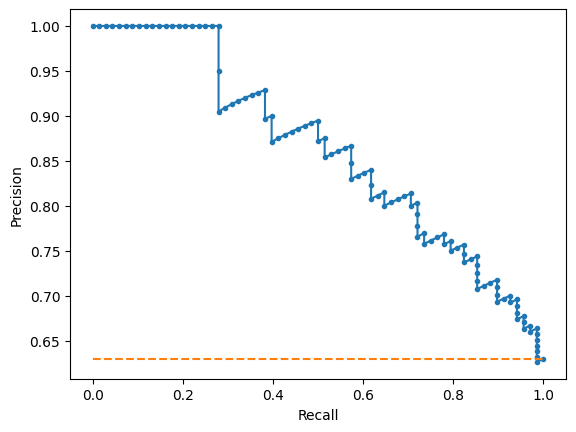

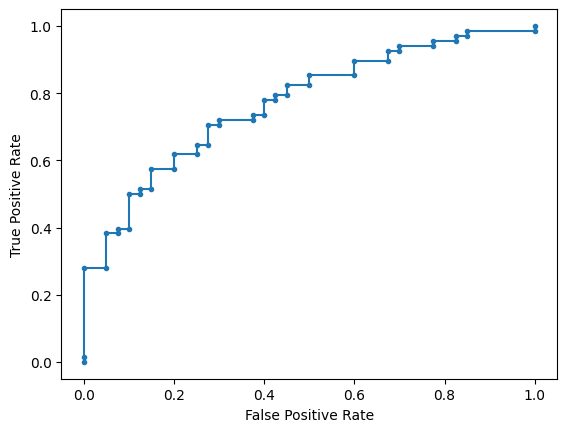

Accuracy: 68.52% Precision: 84.00% Recall: 61.76%
F1: 71.19% MCC: 0.4045
AUPRC: 86.23% AUROC: 77.13%
 accuracy [68.51851851851852]
 precision [84.0]
 recall [61.76470588235294]
 F1 [71.1864406779661]
 MCC [0.40447797724607837]
 AUPRC [86.23084746958385]
 AUROC [77.13235294117648]
 accuracy mean 68.52% std nan
 precision mean 84.00% std nan
 recall mean 61.76% std nan
 F1 mean 71.19% std nan
 MCC mean 0.4045 std nan
 AUPRC mean 86.23% std nan
 AUROC mean 77.13% std nan
 accuracy [[68.51851851851852]]
 precision [[84.0]]
 recall [[61.76470588235294]]
 F1 [[71.1864406779661]]
 MCC [[0.40447797724607837]]
 AUPRC [[86.23084746958385]]
 AUROC [[77.13235294117648]]
2023-04-19 18:14:38.967397


/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [24]:
for cell_line in range(15):
    print()
    print(datetime.now())
    print('Cell Line',cell_line,all_cell_lines[cell_line])

    accuracy=[]
    precision=[]
    recall=[]
    f1=[]
    mcc=[]
    auprc=[]
    auroc=[]

    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TRAIN
    print("Load RCI from",filepath)
    gene_to_rci = loader.load_gene_rci_values(filepath,cell_line)
    print('Num RCI:', len(gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TRAIN
    print('Load sequence from',filepath)
    allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
    print('Loaded',len(allseq),'sequences.')
    test_gene_to_rci = None
    test_allids = None
    test_allseq = None
    if SEQ_FILE_TEST is not None:
        # Train on the entire train set (no cross-validation).
        # Evaluate with the test files.
        test_loader = DataLoader()
        filepath = DATA_DIR+RCI_FILE_TEST
        print("Load RCI from",filepath)
        test_gene_to_rci = test_loader.load_gene_rci_values(filepath,cell_line)
        print('Num RCI:', len(test_gene_to_rci.keys()))
        filepath = DATA_DIR+SEQ_FILE_TEST
        print('Load sequence from',filepath)
        test_allids,test_allseq = test_loader.load_spectra(filepath)
        print('Loaded',len(test_allseq),'sequences.')

    for repeat in range(REPEATS):
        for fold in range(FOLDS):
            show_r = repeat+1  # display one-based counting
            show_f = fold+1    # display one-based counting

            print()
            print("Training #",show_r,show_f)
            print(datetime.now())
            cvdo = CrossValidator(EPOCHS)
            cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
            if SEQ_FILE_TEST is None:
                # Train on 80% and evaluate on 20%.
                separator = Separator()
                separator.load(DATA_DIR,show_r,show_f)
                separator.process(allids,allseq,gene_to_rci)
                train_allids,test_allids = separator.get_ids()
                train_allseq,test_allseq = separator.get_seq()
                train_gene_to_rci,test_gene_to_rci = separator.get_rci()
                cvdo.train_new_model(
                    train_allids,train_allseq,train_gene_to_rci,
                    test_allids,test_allseq,test_gene_to_rci)
                if SAVE_MODEL_FILENAME is not None:
                    filename = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                    cvdo.save_model(filename)
            else:
                # Train on the entire train set (no cross-validation).
                # Evaluate with the test files.
                train_allids = allids
                train_allseq = allseq
                train_gene_to_rci = gene_to_rci
                BREAK = True
                cvdo.train_new_model(
                    train_allids,train_allseq,train_gene_to_rci,
                    None,None,None)

            print()
            print("Testing #",show_r,show_f)
            print(datetime.now())
            cvdo.reset_statistics()
            cvdo.test_without_training(
                test_allids,test_allseq,test_gene_to_rci)
            cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
                cvdo.get_statistics()

            print(" accuracy" ,  cv_accuracy)
            print(" precision" , cv_precision)
            print(" recall" ,    cv_recall)
            print(" F1" ,        cv_f1)
            print(" MCC" ,       cv_mcc)
            print(" AUPRC" ,     cv_auprc)
            print(" AUROC" ,     cv_auroc)

            accuracy.append(cv_accuracy)
            precision.append(cv_precision)
            recall.append(cv_recall)
            f1.append(cv_f1)
            mcc.append(cv_mcc)
            auprc.append(cv_auprc)
            auroc.append(cv_auroc)
            if BREAK: break
        if BREAK: break

    print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
    print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
    print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
    print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
    print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
    print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
    print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

    print(" accuracy"  , accuracy)
    print(" precision" , precision)
    print(" recall"    , recall)
    print(" F1"        , f1)
    print(" MCC"       , mcc)
    print(" AUPRC"     , auprc)
    print(" AUROC"     , auroc)
print(datetime.now())